# Core Concepts - Agents and Communication Patterns

## Understanding AutoGen's Architecture

In this notebook, we'll explore:

1. **Agent Types**: Different types of agents and their roles
2. **Message System**: How agents communicate
3. **Communication Patterns**: Pub/sub, direct messaging, and routing
4. **Custom Agents**: Building your own agent types
5. **Agent Runtime**: Understanding the execution environment

Let's dive deep into AutoGen's core concepts!

## Setup

In [1]:
# Import required libraries
import os
import asyncio
from typing import List, Sequence
from dataclasses import dataclass

# AutoGen imports
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent, BaseChatAgent
from autogen_agentchat.messages import TextMessage, BaseChatMessage
from autogen_agentchat.base import Response
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_core import CancellationToken

# Set up model client
model_client = OpenAIChatCompletionClient(
    model="gpt-4o-mini",
    # api_key=os.environ.get("OPENAI_API_KEY"),
)

## 1. Agent Types in AutoGen

AutoGen provides several built-in agent types, each designed for specific purposes:

### 1.1 AssistantAgent

The most common agent type - powered by an LLM and can use tools:

In [2]:
# AssistantAgent - The AI-powered agent
assistant = AssistantAgent(
    name="ai_assistant",
    model_client=model_client,
    system_message="""You are an AI assistant specialized in explaining technical concepts.
    Be clear, concise, and use examples when helpful.""",
    description="An AI assistant for technical explanations",  # Used in group chats
)

# Test the assistant
result = await assistant.run(task="Explain what an agent is in the context of AI systems.")
print("Assistant's explanation:")
print(result.messages[-1].content)

Assistant's explanation:
In the context of AI systems, an **agent** is an entity that can perceive its environment through sensors and act upon that environment using actuators. Agents are designed to make decisions and execute tasks based on their perceptions and goals.

Agents can be classified in several ways:

1. **Simple Reflex Agents**: These agents operate based on a set of rules that map specific perceptions to actions. For example, a thermostat perceives current room temperature and turns the heating system on or off based on a predefined threshold.

2. **Model-Based Reflex Agents**: These agents maintain an internal state that reflects the history of their interactions with the environment. This allows them to handle more complex tasks. For instance, a self-driving car uses sensors to gauge its surroundings and makes driving decisions based on its learned models of road conditions and traffic rules.

3. **Goal-Based Agents**: These agents can evaluate multiple potential actio

### 1.2 UserProxyAgent

Represents human interaction or executes code/tools without using an LLM:

In [3]:
# UserProxyAgent - For human interaction or tool execution
user_proxy = UserProxyAgent(
    name="user_proxy",
    description="A proxy for user interaction and tool execution",
)

print(f"UserProxyAgent created: {user_proxy.name}")
print(f"Description: {user_proxy.description}")

UserProxyAgent created: user_proxy
Description: A proxy for user interaction and tool execution


## 2. Message System

AutoGen uses a structured message system for agent communication:

In [4]:
from autogen_agentchat.messages import (
    TextMessage, 
)

# Different message types
text_msg = TextMessage(
    content="Hello, I'm a text message!",
    source="example_agent"
)

print(f"Message Type: {type(text_msg).__name__}")
print(f"Content: {text_msg.content}")
print(f"Source: {text_msg.source}")

Message Type: TextMessage
Content: Hello, I'm a text message!
Source: example_agent


Multimodal messages


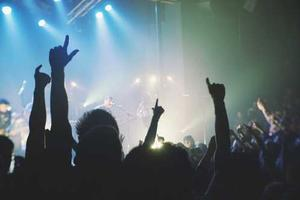

In [6]:
from io import BytesIO

import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image

pil_image = Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = AGImage(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="User")
img

## 3. Agents Deep Dive

Based on the AutoGen tutorial, agents are the fundamental building blocks of any AutoGen application. Let's explore the key concepts:

### 3.1 Common Agent Attributes

All agents in AutoGen share these common attributes:
- **name**: A unique identifier for the agent
- **description**: A text description of what the agent does
- **run()**: Method to execute tasks and return results
- **run_stream()**: Similar to run(), but returns an iterator of messages for streaming responses

### 3.2 Key Agent Features

**AssistantAgent** is the most general-purpose agent type with these capabilities:
- Supports multi-modal input (text, images, etc.)
- Can execute tool calls directly
- Maintains stateful message history
- Flexible enough for most prototyping needs

**Important Note**: While AssistantAgent is great for getting started, you may want to create custom agents for production use cases after understanding its design.

## 4. Teams - Multi-Agent Collaboration

Teams in AutoGen enable multiple agents to work together on complex tasks. They're most effective when a single agent isn't sufficient and diverse expertise is required.

In [ ]:
# Example: Using streaming responses
async for message in agent.run_stream(task="Write a haiku about programming"):
    if hasattr(message, 'content'):
        print(message.content, end="")

In [ ]:
# Example: Creating an AssistantAgent with all common attributes
from autogen_agentchat.agents import AssistantAgent

# AssistantAgent is the most flexible agent type - a "kitchen sink" for prototyping
agent = AssistantAgent(
    name="research_assistant",
    description="An agent that can search the web and analyze information",
    model_client=model_client,
    system_message="You are a helpful research assistant. Use tools when needed to find accurate information."
)

# Running the agent with a task
result = await agent.run(task="What is the capital of France?")
print(f"Agent response: {result.messages[-1].content}")

### 4.1 Team Types

AutoGen provides four primary team configurations:

1. **RoundRobinGroupChat**: Agents take turns responding in sequential order
2. **SelectorGroupChat**: Uses an LLM to dynamically select the next speaker
3. **MagenticOneGroupChat**: A generalist system for open-ended web and file tasks
4. **Swarm**: Uses HandoffMessages for flexible agent transitions

**Key Principle**: Start with single agents, then transition to teams when collaboration adds value.

### 4.2 Key Team Concepts

- **Shared Context**: All agents in a team share conversation history
- **Iterative Problem-Solving**: Teams excel at reflection and improvement cycles
- **Persistence**: Teams maintain state across runs for continuity

In [5]:
# Example: Creating a RoundRobinGroupChat team with reflection pattern
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.conditions import TextMentionTermination

# Create a primary agent and a critic agent
primary_agent = AssistantAgent(
    name="math_solver",
    model_client=model_client,
    system_message="You are a math solver."
)

critic_agent = AssistantAgent(
    name="math_teacher",
    model_client=model_client,
    system_message="You are a math teacher, who gives feedback about a math solver solution to a problem. If the solution is correct, just output 'APPROVED' and say 'You are correct!'"
)

# Create a team with round-robin turns
termination = TextMentionTermination("APPROVED")
team = RoundRobinGroupChat(
    participants=[primary_agent, critic_agent],
    termination_condition=termination
)

# Run the team
result = await team.run(task="How much is 10+10?")

for message in result.messages:
    print(f"{message.source}: {message.content}")

user: How much is 10+10?
math_solver: 10 + 10 = 20.
math_teacher: APPROVED. You are correct!


In [6]:
# Could you map the agent loop example you mentioned with read/summarize/write flow in the Autogen model?

def write_file(file_path: str, content: str):
    """
    Writes the content to the file.
    """
    with open(file_path, "w") as f:
        f.write(content)

def read_file(file_path: str) -> str:
    """
    Reads the content of the file.
    """
    with open(file_path, "r") as f:
        return f.read()


file_operations_agent = AssistantAgent(
    name="file_operations_agent",
    model_client=model_client,
    system_message="You are a file operations agent. You can read and write files using the read_file() and write_file() tools.",
    tools=[read_file, write_file]
)

result = await file_operations_agent.run(task="Read the file ./sample_input.txt and write a summary of it to summary.txt")

In [7]:
for messages in result.messages:
    print(f"{messages.source}: {messages.content}")

user: Read the file ./sample_input.txt and write a summary of it to summary.txt
file_operations_agent: [FunctionCall(id='call_UQGk5KQKHn9xpkRlDD2GKEGb', arguments='{"file_path":"./sample_input.txt"}', name='read_file')]
file_operations_agent: [FunctionExecutionResult(content="'Modern LLM agents are goal-directed systems built around large language models that can plan and act, \nnot just chat. They interact with external tools, services, and environments to achieve outcomes, \niterating through a loop of observing context, planning next steps, taking actions, and using the \nresults to refine their approach. Architecturally, they pair an LLM with a function-calling layer for \ntools and APIs, a memory or state store, and policies that constrain behavior. This enables multi-step \nworkflows such as analyzing datasets, booking travel, triaging support tickets, or orchestrating business \nprocesses end to end.\\n\\nTo stay grounded, agents often augment the model with retrieval so it can 

In [9]:
# Example: Human-in-the-loop with UserProxyAgent
def mock_human_input():
    # In real scenario, this would be actual user input
    return "Yes, proceed with the plan"

assistant = AssistantAgent(
    name="assistant",
    model_client=model_client,
    system_message="You are a helpful assistant."
)

human_proxy = UserProxyAgent(
    name="human_reviewer",
    description="Human reviewer for approval",
    input_func=mock_human_input  # Replace with input() for real interaction
)

# Team with human interaction
human_team = RoundRobinGroupChat(
    participants=[assistant, human_proxy],
    max_turns=2  # Limit interactions
)

print("Human-in-the-loop team configured")

Human-in-the-loop team configured


## 5. Termination Conditions and Human-in-the-Loop

Controlling when conversations end and allowing human intervention are crucial for building robust agent systems.

### 5.1 Termination Conditions

AutoGen provides multiple built-in termination conditions that can be combined:

- **MaxMessageTermination**: Stop after N messages
- **TextMentionTermination**: Stop when specific text appears
- **TokenUsageTermination**: Stop at token threshold
- **TimeoutTermination**: Stop after duration
- **HandoffTermination**: Stop for specific handoff target
- **SourceMatchTermination**: Stop after specific agent responds
- **StopMessageTermination**: Stop on StopMessage

**Key Features**:
- Stateful (track progress across messages)
- Combinable with AND (&) and OR (|) operators
- Auto-reset after each conversation

### 5.2 Human-in-the-Loop Interaction

Two primary approaches for human interaction:

**1. During Team Run (Synchronous)**:
- Use `UserProxyAgent` for real-time feedback
- Blocks execution while waiting for input
- Best for immediate approvals/decisions

In [ ]:
# Example: Combining termination conditions
from autogen_agentchat.conditions import (
    MaxMessageTermination,
    TextMentionTermination,
    TimeoutTermination
)

# Stop after 10 messages OR when "DONE" is mentioned OR after 30 seconds
max_messages = MaxMessageTermination(max_messages=10)
text_mention = TextMentionTermination("DONE")
timeout = TimeoutTermination(timeout_seconds=30)

# Combine with OR operator
combined_termination = max_messages | text_mention | timeout

# Use in a team
team_with_termination = RoundRobinGroupChat(
    participants=[assistant],
    termination_condition=combined_termination
)

print("Team created with combined termination conditions")

**2. Between Team Runs (Asynchronous)**:
- Use `max_turns` to pause execution
- Employ `HandoffTermination` for controlled transfers
- Enables persistent sessions and async communication
- Supports integration with web frameworks (FastAPI, ChainLit)

## 6. Managing State (Simplified Basics)

State management in AutoGen allows agents and teams to save and restore conversation context, essential for building stateless applications and maintaining continuity.

### 6.1 Core State Concepts

- **State Preservation**: Save conversation history and agent context
- **Persistence Options**: Store in files, databases, or memory
- **Cross-Session Continuity**: Resume conversations after restarts
- **Team State**: Save state of all agents in a team

### 6.2 Practical Applications

- **Web Applications**: Maintain conversation context across HTTP requests
- **Long-Running Tasks**: Save progress and resume later
- **Multi-Session Workflows**: Transfer agent knowledge between sessions
- **Debugging**: Save and replay conversation states

**Note**: Custom agents may need to override `save_state()` and `load_state()` methods for specialized state handling.

In [11]:
# Example: Basic state management
# Create an agent
stateful_agent = AssistantAgent(
    name="memory_agent",
    model_client=model_client,
    system_message="You are an agent that remembers conversations."
)

# Run a task
await stateful_agent.run(task="Remember that my favorite color is blue.")

# Save the agent's state
agent_state = stateful_agent.save_state()

# Later, restore the state (simulating a new session)
new_agent = AssistantAgent(
    name="memory_agent",
    model_client=model_client,
    system_message="You are an agent that remembers conversations."
)

# Load the saved state
new_agent.load_state(agent_state)

# The agent remembers the previous conversation
result = await new_agent.run(task="What is my favorite color?")
print(f"Agent recalls: {result.messages[-1].content}")

/var/folders/5l/y8s3fc655417629rqwgxkhx80000gn/T/ipykernel_44251/2717189571.py:23: RuntimeWarning: coroutine 'AssistantAgent.load_state' was never awaited
  new_agent.load_state(agent_state)


Agent recalls: I'm sorry, but I don't have that information. What is your favorite color?


## Summary

You've now learned the expanded core concepts of AutoGen! Let's recap what we covered:

✅ **Section 1-2**: Agent Types and Message System (existing content)

✅ **Section 3**: Agents Deep Dive
- Common agent attributes (name, description, run(), run_stream())
- AssistantAgent as the flexible "kitchen sink" for prototyping
- Multi-modal support and tool execution capabilities

✅ **Section 4**: Teams - Multi-Agent Collaboration
- Four team types (RoundRobin, Selector, MagenticOne, Swarm)
- Reflection patterns for iterative improvement
- When to use teams vs single agents

✅ **Section 5**: Termination Conditions and Human-in-the-Loop
- Seven termination condition types
- Combining conditions with AND/OR operators
- Synchronous and asynchronous human interaction patterns
- UserProxyAgent for human feedback

✅ **Section 6**: Managing State (Basics)
- State preservation and restoration
- Cross-session continuity
- Practical applications in web apps and long-running tasks